<a href="https://colab.research.google.com/github/henriquemin/portfolio_data_science/blob/master/Retail_Market_Basket_Analysis_Apriori.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Retail Market Basket Analysis**
---


* In retail market finding a new way to increase sales and customer engagement 
are the most common and difficult task to deal. Increase the number of competitors, economy, seazonal issues, there are a lot of features that 
influence in this market.

* To have advatange in retail, Retailers must know better the customer than your competitors to make them buy more in your business than to other.
To do that is very important to understand the customer behavior, store layout and do customized offers to this customer.

* Thinking about that Machine Learning can help to understand the customer behavior and analyze the sales history to make predictions to boost the sales. And one option to do that is using Market Basket Analysis, that is a method to understand the combination of items that estimulate more sales.

* This project I am going to use Apriori algorithm to develop a Market Basket Analysis to make prediction on how products can be organized inside the store to develop new strategies for customers.

Os relacionamentos descobertos não são inerentes aos exemplos e eles não representam nenhum tipo de causa ou correlação
Ao invés, RAs detectam o uso comum de itens

# **Apriori Dataset model 1**

## **Exploratory Data Analysis (EDA)**
---

Doing EDA will help to understand the dataset and which features to select to find the label of prediction


### Import Libraries







In [0]:
#pip install pandas mlxtend

In [0]:
# Importation of libraries
import pandas as pd
import numpy as np
import io
from google.colab import files

import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import mlxtend as ml


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Load file & Data preparation







In [0]:
# Opening the file into Google Colab 
upload_file = files.upload()
print(f'File(s) uploaded!')

Saving Online Retail.xlsx to Online Retail.xlsx
File(s) uploaded!


In [0]:
# Creating the dataset
df_initial = pd.read_excel(io.BytesIO(upload_file['Online Retail.xlsx']), header = 0)
df_initial.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom



### Identifying Features & Labels

In [0]:
# Dataset info
display(df_initial.info())
print('\n')

# Descriptive statistics of the data
display(df_initial.describe())
print('\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


None

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


### Missing Value Identification

In [0]:
# Identify null values on dataset

print('  ' * 10 + " Display information about column types and number of null values " + '  ' * 10 )
print('--' * 50)

tab_info = pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info = tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values'}))
tab_info = tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.rename(index={0:'null values (%)'}))

if(any(df_initial.isnull().any())):
    print()
    display(tab_info)
else:
    print('NO missing data')

                     Display information about column types and number of null values                     
----------------------------------------------------------------------------------------------------



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,float64,object
null values,0,0,1454,0,0,0,135080,0
null values (%),0,0,0.268311,0,0,0,24.9267,0


### Check for hidden missing values


In [0]:
#Let's check the 'hide' missing values (values = 0) in the dataset
def check_hide_missing_values(*columns):
    for column in columns:
        print("Missing rows: {0}      for " .format(len(df_initial.loc[df_initial[column] == 0])),column)

check_hide_missing_values('InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',"UnitPrice", 'CustomerID', 'Country')
print("Total rows:   {0} for Dataframe" .format(len(df_initial)))
# This dataset don`t have missing values, but there are zero values on columns: ['UnitPrice'], but as I will do a MBA it will not affect the project

Missing rows: 0      for  InvoiceNo
Missing rows: 0      for  StockCode
Missing rows: 0      for  Description
Missing rows: 0      for  Quantity
Missing rows: 0      for  InvoiceDate
Missing rows: 2515      for  UnitPrice
Missing rows: 0      for  CustomerID
Missing rows: 0      for  Country
Total rows:   541909 for Dataframe


### Verify InvoiceNo column


In [0]:
# There are some invoices that have "C" in the InvoiceNo field. It represents 'Credit or Discount' for this customer.
df_initial[df_initial.InvoiceNo.str.contains('C', na=False)].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


In [0]:
# To remove these "C" invoices, find all those invoices, and take the inverse of the results.
# But 1st let's change the InvoiceNo column into string
df_initial['InvoiceNo'] = df_initial['InvoiceNo'].astype('str')

df_initial = df_initial[~df_initial['InvoiceNo'].str.contains('C')]

In [0]:
# Check if the column InvoiceNo still have "C"
df_initial[df_initial.InvoiceNo.str.contains('C', na=False)].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


### Exploring data attributes

In [0]:
group = df_initial.groupby(['Description']).sum().sort_values(by='Quantity', ascending= False)
group

,Quantity,UnitPrice,CustomerID
Description,,,
"PAPER CRAFT , LITTLE BIRDIE",80995,2.08,16446.0
MEDIUM CERAMIC TOP STORAGE JAR,78033,367.12,3047321.0
WORLD WAR 2 GLIDERS ASSTD DESIGNS,55047,172.20,7226036.0
JUMBO BAG RED RETROSPOT,48478,5249.29,24748363.0
WHITE HANGING HEART T-LIGHT HOLDER,37895,7472.97,31562068.0
...,...,...,...
Damaged,-7540,0.00,0.0
Printing smudges/thrown away,-9058,0.00,0.0
check,-12030,0.00,0.0


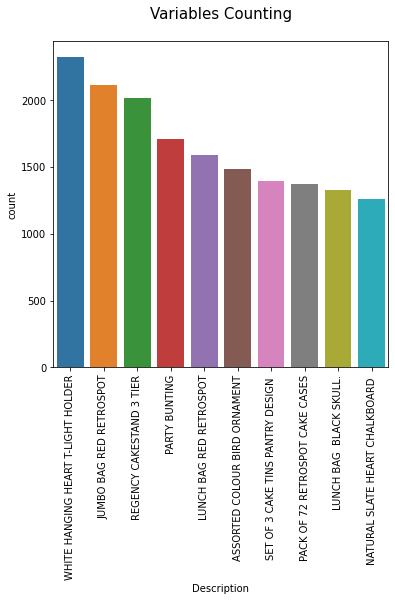

In [0]:
# Most selling item ranking
plt.figure(figsize=(6,6))
plt.xticks(rotation=90)
plt.title('Variables Counting', y=1.05, size=15)
sns.countplot(x= 'Description', data = df_initial, order=df_initial['Description'].value_counts().iloc[:10].index)
sns.set(font_scale=1)

plt.show()

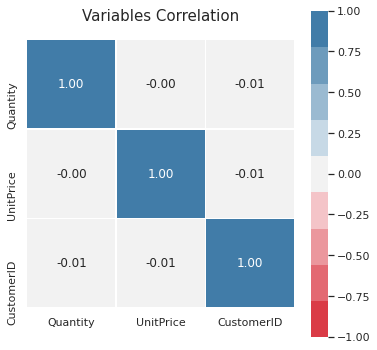

In [0]:
# Heatmap, to identify the correlation between the features. Obs: Correlation do not shows causation
corr = df_initial.corr()

#plt.title('Titanic - Features Correlation',  size=15)
#ax = sns.heatmap(corr, vmin= -1,  vmax = 1, linewidths=0.3, center = 0, cmap = sns.diverging_palette(10, 240, n=9), square = True, annot= True )
#ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, horizontalalignment = 'right')

plt.figure(figsize=(6,6))
plt.title('Variables Correlation', y=1.05, size=15)
sns.set(font_scale=1)

ax = sns.heatmap(corr, fmt= '.2f',linewidths=0.3, vmin= -1,vmax=1.0, square=True, cmap= sns.diverging_palette(10, 240, n=9), linecolor='white', annot=True);

## **Machine Learning Algorithm**
---

### Preparing the dataset to Machine Learning

In [0]:
# Define dataset to machine learning
market_basket = df_initial[(df_initial['Country'] == "United Kingdom") & (df_initial['Quantity'] >= 1)].groupby(['InvoiceNo', 'Description'])['Quantity']
market_basket = market_basket.sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')

market_basket.head()

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TOADSTOOL BEDSIDE LIGHT,TRELLIS COAT RACK,*Boombox Ipod Classic,*USB Office Mirror Ball,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,12 PENCILS TALL TUBE WOODLAND,12 PINK HEN+CHICKS IN BASKET,12 PINK ROSE PEG PLACE SETTINGS,12 RED ROSE PEG PLACE SETTINGS,15 PINK FLUFFY CHICKS IN BOX,15CM CHRISTMAS GLASS BALL 20 LIGHTS,16 PC CUTLERY SET PANTRY DESIGN,16 PIECE CUTLERY SET PANTRY DESIGN,18PC WOODEN CUTLERY SET DISPOSABLE,2 DAISIES HAIR COMB,2 PICTURE BOOK EGGS EASTER BUNNY,2 PICTURE BOOK EGGS EASTER CHICKS,2 PICTURE BOOK EGGS EASTER DUCKS,20 DOLLY PEGS RETROSPOT,...,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY,add stock to allocate online orders,adjustment,alan hodge cant mamage this section,allocate stock for dotcom orders ta,amazon,amazon adjust,amazon sales,came coded as 20713,check,check?,damaged,did a credit and did not tick ret,dotcom,dotcom adjust,dotcomstock,for online retail orders,found,found box,had been put aside,incorrectly credited C550456 see 47,mailout,mailout,michel oops,on cargo order,rcvd be air temp fix for dotcom sit,returned,taig adjust,test,to push order througha s stock was,website fixed,wrongly coded 20713,wrongly coded 23343,wrongly marked,wrongly marked 23343,wrongly sold (22719) barcode
InvoiceNo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
536365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
market_basket = df_initial[df_initial['Country'] == "United Kingdom"].groupby(['InvoiceNo', 'Description'])['Quantity']

# One hot encoder processing
market_basket = market_basket.sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')
market_basket.head()

Description,20713,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TOADSTOOL BEDSIDE LIGHT,TRELLIS COAT RACK,*Boombox Ipod Classic,*USB Office Mirror Ball,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,12 PENCILS TALL TUBE WOODLAND,12 PINK HEN+CHICKS IN BASKET,12 PINK ROSE PEG PLACE SETTINGS,12 RED ROSE PEG PLACE SETTINGS,15 PINK FLUFFY CHICKS IN BOX,15CM CHRISTMAS GLASS BALL 20 LIGHTS,16 PC CUTLERY SET PANTRY DESIGN,16 PIECE CUTLERY SET PANTRY DESIGN,18PC WOODEN CUTLERY SET DISPOSABLE,2 DAISIES HAIR COMB,2 PICTURE BOOK EGGS EASTER BUNNY,2 PICTURE BOOK EGGS EASTER CHICKS,2 PICTURE BOOK EGGS EASTER DUCKS,...,sold as set on dotcom,sold as set on dotcom and amazon,sold as set/6 by dotcom,sold in set?,sold with wrong barcode,stock check,stock creditted wrongly,taig adjust,taig adjust no stock,temp adjustment,test,throw away,thrown away,thrown away-can't sell,thrown away-can't sell.,to push order througha s stock was,water damage,water damaged,website fixed,wet,wet boxes,wet damaged,wet pallet,wet rusty,wet/rusty,wet?,wrong barcode,wrong barcode (22467),wrong code,wrong code?,wrongly coded 20713,wrongly coded 23343,wrongly coded-23343,wrongly marked,wrongly marked 23343,wrongly marked carton 22804,wrongly marked. 23343 in box,wrongly sold (22719) barcode,wrongly sold as sets,wrongly sold sets
InvoiceNo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
536365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
# Convert all of our numbers to either a 1 or a 0 (negative numbers are converted to zero, positive numbers are converted to 1)
def encode_data(datapoint):
  if datapoint <= 0:
    return 0
  else:
    return 1

In [0]:
# Process the transformation into the market_basket dataset
market_basket = market_basket.applymap(encode_data)


# Check the result
market_basket.head()

Description,20713,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TOADSTOOL BEDSIDE LIGHT,TRELLIS COAT RACK,*Boombox Ipod Classic,*USB Office Mirror Ball,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,12 PENCILS TALL TUBE WOODLAND,12 PINK HEN+CHICKS IN BASKET,12 PINK ROSE PEG PLACE SETTINGS,12 RED ROSE PEG PLACE SETTINGS,15 PINK FLUFFY CHICKS IN BOX,15CM CHRISTMAS GLASS BALL 20 LIGHTS,16 PC CUTLERY SET PANTRY DESIGN,16 PIECE CUTLERY SET PANTRY DESIGN,18PC WOODEN CUTLERY SET DISPOSABLE,2 DAISIES HAIR COMB,2 PICTURE BOOK EGGS EASTER BUNNY,2 PICTURE BOOK EGGS EASTER CHICKS,2 PICTURE BOOK EGGS EASTER DUCKS,...,sold as set on dotcom,sold as set on dotcom and amazon,sold as set/6 by dotcom,sold in set?,sold with wrong barcode,stock check,stock creditted wrongly,taig adjust,taig adjust no stock,temp adjustment,test,throw away,thrown away,thrown away-can't sell,thrown away-can't sell.,to push order througha s stock was,water damage,water damaged,website fixed,wet,wet boxes,wet damaged,wet pallet,wet rusty,wet/rusty,wet?,wrong barcode,wrong barcode (22467),wrong code,wrong code?,wrongly coded 20713,wrongly coded 23343,wrongly coded-23343,wrongly marked,wrongly marked 23343,wrongly marked carton 22804,wrongly marked. 23343 in box,wrongly sold (22719) barcode,wrongly sold as sets,wrongly sold sets
InvoiceNo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Building the Apriori model

*   Support (Suporte): 
  * nº de ocorrências dos itens (1,2) juntos / nº de ocorrências total
  * Indica se a relação entre os itens é alta ou baixa em relação ao total de ocorrências
  * 'antecedent support' calcula nº de ocorrências do item 1
  * 'consequent support' calcula nº de ocorrências do item 2
  * 'support' calcula a combinação acima entre itens 1 e 2


*   Confidence (Confiança): 
  * nº de ocorrências do item 2 junto do item 1 / nº de ocorrências do item 1
  * Probabilidade do item 2 aparecer em uma transação em que há o item 1
  * Se valor = 1 (max) indica que os 2 itens sempre são comprados juntos

*   Lift (Alavancagem): 
  * suporte (1,2) / suporte item 1 * suporte item 2
  * Quanto o item 1 alavanca nas vendas do item 2
  * Se valor < 1, ocorreu ao acaso. Se valor > 1 houve alavancagem. Se valor = 1, são independentes

*   Leverage:
  * Calcula a diferença entre as ocorrências do item 1 e 2 acontecerem juntas e a frequencia esperada se o item 1 e 2 são independentes
  * Valor = 0 indica independência

*   Conviction:
   * Valor alto significa que o item 2 é altamente dependente do item 1. 
   * Se valor = 1, são independentes

In [0]:
# Apriori method request a min_support: Support is defined as the percentage of time that an itemset appears in the dataset.
# Defined to start seeing data/results with min_support of 3%
itemsets = apriori(market_basket, min_support= 0.03, use_colnames=True)

In [0]:
# Build your association rules using the mxltend association_rules function.
# min_threshold can be thought of as the level of confidence percentage that you want to return
# Defined to use 50% of min_threshold
rules = association_rules(itemsets, metric='lift', min_threshold=0.5)

In [0]:
# it have us a result of 20 product sales combinations
# It can use this information to build a cross-sell recommendation system that promotes these products with each other 
rules.sort_values(by=['lift'], ascending = False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.037658,0.050032,0.030909,0.820768,16.404818,0.029024,5.300218
3,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.050032,0.037658,0.030909,0.617773,16.404818,0.029024,2.517724
4,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.050032,0.051264,0.037551,0.750535,14.640537,0.034986,3.803087
5,(ROSES REGENCY TEACUP AND SAUCER ),(GREEN REGENCY TEACUP AND SAUCER),0.051264,0.050032,0.037551,0.732497,14.640537,0.034986,3.551247
0,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED ),0.046925,0.049818,0.030159,0.642694,12.900874,0.027821,2.659296
1,(ALARM CLOCK BAKELIKE RED ),(ALARM CLOCK BAKELIKE GREEN),0.049818,0.046925,0.030159,0.605376,12.900874,0.027821,2.415149
14,(LUNCH BAG BLACK SKULL.),(LUNCH BAG RED RETROSPOT),0.065138,0.074566,0.032516,0.499178,6.694431,0.027658,1.847829
15,(LUNCH BAG RED RETROSPOT),(LUNCH BAG BLACK SKULL.),0.074566,0.065138,0.032516,0.436063,6.694431,0.027658,1.657742
9,(JUMBO BAG RED RETROSPOT),(JUMBO BAG PINK POLKADOT),0.103814,0.062085,0.042051,0.405057,6.524245,0.035605,1.576478
8,(JUMBO BAG PINK POLKADOT),(JUMBO BAG RED RETROSPOT),0.062085,0.103814,0.042051,0.677308,6.524245,0.035605,2.777218


### Recommendations filter


* Objetivo: 
  * Identificar quais produtos influenciam nas vendas de outros 
  * Medir a relação de alavancagem entre os itens
  * Geral: Identifica os itens independente da categoria
  * Por departamento: relação entre itens do mesmo setor

* Estrutura:
  1. Analisar cesta de compras (Histórico geral da loja e por marca)
  2. Verificar as relações mais relevantes/importantes
  3. Analisar layout dos produtos na loja
  4. Propor melhorias

In [0]:
# Recommendation of Market Basket
rec_rules = rules[ (rules['lift'] >= 6) & (rules['confidence'] >= 0.6) ]

### Save Market Basket Analysis

In [0]:
# Defining the dataset to be saved
cols_keep = {'antecedents':'item_1', 'consequents':'item_2', 'support':'suporte', 'confidence':'confianca', 'lift':'alavancagem'}
cols_drop = ['antecedent support', 'consequent support', 'leverage', 'conviction']

cesta_compras = pd.DataFrame(rec_rules).rename(columns= cols_keep).drop(columns=cols_drop).sort_values(by=['alavancagem'], ascending = False)
cesta_compras['item_1'] = cesta_compras['item_1'].str.join('()')
cesta_compras['item_2'] = cesta_compras['item_2'].str.join('()')
display(cesta_compras)

# Saving into .csv file
cesta_compras.to_csv('cesta_compras.csv', index=False)

print('\n')
print(f'File saved!')

,item_1,item_2,suporte,confianca,alavancagem
2,PINK REGENCY TEACUP AND SAUCER,GREEN REGENCY TEACUP AND SAUCER,0.030909,0.820768,16.404818
3,GREEN REGENCY TEACUP AND SAUCER,PINK REGENCY TEACUP AND SAUCER,0.030909,0.617773,16.404818
4,GREEN REGENCY TEACUP AND SAUCER,ROSES REGENCY TEACUP AND SAUCER,0.037551,0.750535,14.640537
5,ROSES REGENCY TEACUP AND SAUCER,GREEN REGENCY TEACUP AND SAUCER,0.037551,0.732497,14.640537
0,ALARM CLOCK BAKELIKE GREEN,ALARM CLOCK BAKELIKE RED,0.030159,0.642694,12.900874
1,ALARM CLOCK BAKELIKE RED,ALARM CLOCK BAKELIKE GREEN,0.030159,0.605376,12.900874
8,JUMBO BAG PINK POLKADOT,JUMBO BAG RED RETROSPOT,0.042051,0.677308,6.524245
6,JUMBO BAG BAROQUE BLACK WHITE,JUMBO BAG RED RETROSPOT,0.030534,0.626374,6.033613




File saved!


Reference: https://pythondata.com/market-basket-analysis-with-python-and-pandas/

# **Apriori Dataset model 2**

## **Exploratory Data Analysis (EDA)**
---

Doing EDA will help to understand the dataset and which features to select to find the label of prediction


### Import Libraries







In [0]:
pip install apyori

  Created wheel for apyori: filename=apyori-1.1.2-cp36-none-any.whl size=5975 sha256=e68a445c1b39589aa713c56f61eea52ca8ba7dd67bc06c00913da37f7fd212cd
  Stored in directory: /root/.cache/pip/wheels/5d/92/bb/474bbadbc8c0062b9eb168f69982a0443263f8ab1711a8cad0
Successfully built apyori


In [0]:
# Importation of libraries
import pandas as pd
import numpy as np
import io
from google.colab import files

import matplotlib.pyplot as plt
import seaborn as sns

from apyori import apriori

### Load file & Data preparation







In [0]:
# Opening the file into Google Colab 
upload_file = files.upload()
print(f'File(s) uploaded!')

Saving Market_Basket_Optimisation.csv to Market_Basket_Optimisation.csv
File(s) uploaded!


In [0]:
# Creating the dataset
df_model_2 = pd.read_csv('Market_Basket_Optimisation.csv', header = None)
df_model_2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil
1,burgers,meatballs,eggs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chutney,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,turkey,avocado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mineral water,milk,energy bar,whole wheat rice,green tea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
# Transform the NaN values into zeros
df_model_2.fillna(0,inplace=True)
df_model_2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil
1,burgers,meatballs,eggs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,chutney,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,turkey,avocado,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,mineral water,milk,energy bar,whole wheat rice,green tea,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# Create a list of each transaction
transactions = []
for i in range(0,len(df_model_2)):
    transactions.append([str(df_model_2.values[i,j]) for j in range(0,20) if str(df_model_2.values[i,j])!='0'])

In [0]:
# Check the 1st order transaction
transactions[0]

['shrimp',
 'almonds',
 'avocado',
 'vegetables mix',
 'green grapes',
 'whole weat flour',
 'yams',
 'cottage cheese',
 'energy drink',
 'tomato juice',
 'low fat yogurt',
 'green tea',
 'honey',
 'salad',
 'mineral water',
 'salmon',
 'antioxydant juice',
 'frozen smoothie',
 'spinach',
 'olive oil']

## **Machine Learning Algorithm**
---

### Building the Apriori model

*   Support (Suporte): 
  * nº de ocorrências dos itens (1,2) juntos / nº de ocorrências total
  * Indica se a relação entre os itens é alta ou baixa em relação ao total de ocorrências
  * 'antecedent support' calcula nº de ocorrências do item 1
  * 'consequent support' calcula nº de ocorrências do item 2
  * 'support' calcula a combinação acima entre itens 1 e 2


*   Confidence (Confiança): 
  * nº de ocorrências do item 2 junto do item 1 / nº de ocorrências do item 1
  * Probabilidade do item 2 aparecer em uma transação em que há o item 1
  * Se valor = 1 (max) indica que os 2 itens sempre são comprados juntos

*   Lift (Alavancagem): 
  * suporte (1,2) / suporte item 1 * suporte item 2
  * Quanto o item 1 alavanca nas vendas do item 2
  * Se valor < 1, ocorreu ao acaso. Se valor > 1 houve alavancagem. Se valor = 1, são independentes

*   Leverage:
  * Calcula a diferença entre as ocorrências do item 1 e 2 acontecerem juntas e a frequencia esperada se o item 1 e 2 são independentes
  * Valor = 0 indica independência

*   Conviction:
   * Valor alto significa que o item 2 é altamente dependente do item 1. 
   * Se valor = 1, são independentes

In [0]:
# Apriori method request a min_support: Support is defined as the percentage of time that an itemset appears in the dataset.
# Defined to start seeing data/results with min_support of 3%

rules = apriori(transactions,min_support=0.003,min_confidance=0.2,min_lift=3,min_length=2)
print(rules)

<generator object apriori at 0x7f55e1f3ca98>


In [0]:
# Create the list of transaction lists
Results = list(rules)
Results

[RelationRecord(items=frozenset({'brownies', 'cottage cheese'}), support=0.0034662045060658577, ordered_statistics=[OrderedStatistic(items_base=frozenset({'brownies'}), items_add=frozenset({'cottage cheese'}), confidence=0.10276679841897232, lift=3.225329518580382), OrderedStatistic(items_base=frozenset({'cottage cheese'}), items_add=frozenset({'brownies'}), confidence=0.10878661087866107, lift=3.2253295185803816)]),
 RelationRecord(items=frozenset({'chicken', 'light cream'}), support=0.004532728969470737, ordered_statistics=[OrderedStatistic(items_base=frozenset({'chicken'}), items_add=frozenset({'light cream'}), confidence=0.07555555555555556, lift=4.843950617283951), OrderedStatistic(items_base=frozenset({'light cream'}), items_add=frozenset({'chicken'}), confidence=0.29059829059829057, lift=4.84395061728395)]),
 RelationRecord(items=frozenset({'mushroom cream sauce', 'escalope'}), support=0.005732568990801226, ordered_statistics=[OrderedStatistic(items_base=frozenset({'escalope'}),

In [0]:
# Transform the Results into a pd.Dataframe
df_results = pd.DataFrame(Results)
df_results.head()

,items,support,ordered_statistics
0,"(brownies, cottage cheese)",0.003466,"[((brownies), (cottage cheese), 0.102766798418..."
1,"(chicken, light cream)",0.004533,"[((chicken), (light cream), 0.0755555555555555..."
2,"(mushroom cream sauce, escalope)",0.005733,"[((escalope), (mushroom cream sauce), 0.072268..."
3,"(escalope, pasta)",0.005866,"[((escalope), (pasta), 0.07394957983193277, 4...."
4,"(tomato juice, fresh bread)",0.004266,"[((fresh bread), (tomato juice), 0.09907120743..."


In [0]:
# Separate and append the df_results items and statiscts on each list
first_values  = []   # item 1
second_values = []   # item 2
third_values  = []   # confidence
fourth_value  = []   # lift

for i in range(df_results.shape[0]):

    # Select values in the ordered_statistics column
    single_list = df_results['ordered_statistics'][i][0]

    # Instantiate the values on each list
    first_values.append(list(single_list[0]))   # basket item 1 list
    second_values.append(list(single_list[1]))  # basket item 2 list
    third_values.append(single_list[2])         # Confidence value
    fourth_value.append(single_list[3])         # Lift value

In [0]:
# Creating the dataframe of each list and transform into a column
first = pd.DataFrame([first_values]).T
second = pd.DataFrame([second_values]).T
support = df_results.support
confidence = pd.DataFrame(third_values,columns=['Confidance'])
lift = pd.DataFrame(fourth_value,columns=['lift'])

In [0]:
# Concatenate all dataframe columns into a single dataframe
df_final = pd.concat([first,second,support,confidence,lift], axis=1)
df_final.columns = ['item_1','item_2','support','confidence','lift']
df_final.sort_values(by=['lift'], ascending = False)

,item_1,item_2,support,confidence,lift
58,[olive oil],"[mineral water, whole wheat pasta]",0.003866,0.058704,6.115863
6,[fromage blanc],[honey],0.003333,0.245098,5.164271
49,[ground beef],"[spaghetti, tomato sauce]",0.003066,0.031208,4.980600
1,[chicken],[light cream],0.004533,0.075556,4.843951
3,[escalope],[pasta],0.005866,0.073950,4.700812
...,...,...,...,...,...
70,"[chocolate, frozen vegetables]","[spaghetti, mineral water]",0.004133,0.180233,3.017688
92,"[milk, mineral water]","[spaghetti, shrimp]",0.003066,0.063889,3.014029
36,[shrimp],"[spaghetti, frozen vegetables]",0.005999,0.083955,3.013149
71,"[chocolate, ground beef]","[milk, mineral water]",0.003333,0.144509,3.010999


### Recommendations filter


* Objetivo: 
  * Identificar quais produtos influenciam nas vendas de outros 
  * Medir a relação de alavancagem entre os itens
  * Geral: Identifica os itens independente da categoria
  * Por departamento: relação entre itens do mesmo setor

* Estrutura:
  1. Analisar cesta de compras (Histórico geral da loja e por marca)
  2. Verificar as relações mais relevantes/importantes
  3. Analisar layout dos produtos na loja
  4. Propor melhorias

In [0]:
# Recommendation of Market Basket
mba_filter = df_final[(df_final['lift'] >= 2) & (df_final['confidence'] >= 0.15)]
mba_recommendation = mba_filter.sort_values(by='lift', ascending=False)

print('Total Market Basket Recommendation: {}' .format(len(mba_recommendation)))
print('\n')
display(mba_recommendation)

Total Market Basket Recommendation: 13




,item_1,item_2,support,confidence,lift
6,[fromage blanc],[honey],0.003333,0.245098,5.164271
11,[pasta],[shrimp],0.005066,0.322034,4.506672
5,[fresh tuna],[honey],0.003999,0.179641,3.785070
89,"[ground beef, pancakes]","[spaghetti, mineral water]",0.003066,0.211009,3.532991
51,[soup],"[milk, mineral water]",0.008532,0.168865,3.518499
76,"[ground beef, eggs]","[milk, mineral water]",0.003333,0.166667,3.472685
50,[light cream],"[spaghetti, mineral water]",0.003200,0.205128,3.434524
87,"[ground beef, milk]","[spaghetti, mineral water]",0.004399,0.200000,3.348661
7,[ground beef],[herb & pepper],0.015998,0.162822,3.291994
77,"[ground beef, eggs]","[spaghetti, mineral water]",0.003866,0.193333,3.237039


### Save Market Basket Analysis

In [0]:

mba_recommendation['item_1'] = mba_recommendation['item_1'].str.join(',')
mba_recommendation['item_2'] = mba_recommendation['item_2'].str.join(',')

# Saving the market basket analysis into .csv file
mba_recommendation.to_csv('mba_recommendation.csv', index=False)